Hello, I am Dmitry, your team lead for this project. I will focus on checking your plan and your report. I may look through your code lightly if I need to link your plan/report back to the data.

You will find my comments in the boxes like these

<div class="alert alert-block alert-success">
<b>Success/Comment:</b> everything looks good, done correctly or it is just a generic comment.
</div>

<div class="alert alert-block alert-info">
<b>Improve: </b> warnings, non-critical issues; eliminating them can make your project better.
</div>

<div class="alert alert-block alert-danger">
<b>Needs fixing:</b> there is something critical which requires correction, a project is not accepted with open red comments.
</div>

</span>

<font color='orange'>**2020-09-26 General Feedback on Report**</font>

The report is fine, it allows seeing what kind of work has been done and suggest further actions.

<font color='orange'>**2020-09-26 General Feedback on Project**</font>

There have been several models built and compared. This is plus. That'd be even greater if you have tried to tune hyperparameters for CatBoost/XGBoost. I feel ROC-AUC over 0.95 might be quite easy to reach with the tuning.

<font color='orange'>**2020-09-21 General Feedback on Project**</font>

CB/XGBoost shows some improvement over RF and they will probably be good enough to demo to our customer. BUt I am really missing output for the last cells in your notebook. Can you please run it and submit with the output for all the cells?

<font color='orange'>**2020-09-17 General Feedback on Plan**</font>

Thank you for the plan. It looks good. The first point in it is really about focusing on EDA to 'understand' the data. However, I can see you've already included some modelling in it which is good. Can you please just ensure you've run all cells in the notebook before submitting it for the peer-to-peer review?

# 1. Project Description
The telecom operator Interconnect would like to be able to forecast their churn of clients. 

If it's discovered that a user is planning to leave, they will be offered promotional codes and special plan options. 

We were given data in 4 separated files. These files include the following information:
## Types of services:
1.	Landline communication - 1 or 2 lines.
2.	Internet - The network can be set up via DSL (telephone) or Fiber optics.

## Additional value-added services
- Antivirus software (DeviceProtection)
- Malicious website blocker (OnlineSecurity)
- Technical support line (TechSupport)
- Cloud file storage and data backup (OnlineBackup)
- TV streaming (StreamingTV
- Movie directory (StreamingMovies)

## Billing and Charging
- Payment plan: Clients can choose monthly payment or 1- or 2-year contract. - - Payment method: Bank transfer (automatic) / Credit card (automatic) /Electronic check / Mailed check
- Invoice: paper or electronic

## Our mission:
- Create a model that predict churn
- Analyse which factors are influencing churn and come up with recommendations accordingly

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.ticker import MultipleLocator
import seaborn as sns
from IPython.display import display
import scipy.stats as ss
import sklearn.metrics as metrics
from sklearn.metrics import f1_score, roc_auc_score
from sklearn.model_selection import train_test_split
!pip install catboost
from catboost import CatBoostClassifier
import lightgbm as lgbm
from sklearn.ensemble import RandomForestClassifier

pd.set_option('display.max_rows', 50)
pd.set_option('display.width', 200)
pd.set_option('display.max_columns', None)
pd.options.display.float_format = '{:11,.2f}'.format
np.set_printoptions(precision=2)

Defaulting to user installation because normal site-packages is not writeable


# 2. Data Preparation

## 2.1 Load the data coming from 4 CSV files

In [2]:
colab = False
if colab:
    data_path = 'https://raw.githubusercontent.com/dnevo/Practicum/master/datasets/'
else:
    data_path = '/datasets/final_provider/'
df_phone = pd.read_csv(data_path + 'phone.csv')
df_personal = pd.read_csv(data_path + 'personal.csv')
df_internet = pd.read_csv(data_path + 'internet.csv')
df_contract = pd.read_csv(data_path + 'contract.csv')

## 2.2 Combining together the data into a single dataframe

In [3]:
df_customer = pd.merge(pd.merge(pd.merge(
    df_personal, 
    df_phone, on='customerID', how='outer'), 
    df_internet, on='customerID', how='outer'), 
    df_contract, on='customerID', how='outer')

## 2.3 Initial data overview

In [4]:
df_customer.head()

,customerID,gender,SeniorCitizen,Partner,Dependents,MultipleLines,InternetService,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,BeginDate,EndDate,Type,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges
0,7590-VHVEG,Female,0,Yes,No,NaN,DSL,No,Yes,No,No,No,No,2020-01-01,No,Month-to-month,Yes,Electronic check,29.85,29.85
1,5575-GNVDE,Male,0,No,No,No,DSL,Yes,No,Yes,No,No,No,2017-04-01,No,One year,No,Mailed check,56.95,1889.5
2,3668-QPYBK,Male,0,No,No,No,DSL,Yes,Yes,No,No,No,No,2019-10-01,2019-12-01 00:00:00,Month-to-month,Yes,Mailed check,53.85,108.15
3,7795-CFOCW,Male,0,No,No,NaN,DSL,Yes,No,Yes,Yes,No,No,2016-05-01,No,One year,No,Bank transfer (automatic),42.30,1840.75
4,9237-HQITU,Female,0,No,No,No,Fiber optic,No,No,No,No,No,No,2019-09-01,2019-11-01 00:00:00,Month-to-month,Yes,Electronic check,70.70,151.65


In [5]:
df_customer.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 7043 entries, 0 to 7042
Data columns (total 20 columns):
customerID          7043 non-null object
gender              7043 non-null object
SeniorCitizen       7043 non-null int64
Partner             7043 non-null object
Dependents          7043 non-null object
MultipleLines       6361 non-null object
InternetService     5517 non-null object
OnlineSecurity      5517 non-null object
OnlineBackup        5517 non-null object
DeviceProtection    5517 non-null object
TechSupport         5517 non-null object
StreamingTV         5517 non-null object
StreamingMovies     5517 non-null object
BeginDate           7043 non-null object
EndDate             7043 non-null object
Type                7043 non-null object
PaperlessBilling    7043 non-null object
PaymentMethod       7043 non-null object
MonthlyCharges      7043 non-null float64
TotalCharges        7043 non-null object
dtypes: float64(1), int64(1), object(18)
memory usage: 1.1+ MB


## 2.4 Initial assessment
- There is a total of 7043 rows
- The data is unlabelled - churn can be concluded via `EndItime` - No churn if equal to `No`, and churn otherwise.
- Internet value-added features: in addition to Yes and No there are also many NaNs: 1,526 (=7043-5517) out of 7043. We assume (to be confirmed with the data owner) that they indicate cases of customers with telephone services and without internet.
- `MultipleLines`: in addition to Yes and No there are also many NaNs: 682 (=7043-6361) out of 7043. We assume (to be confirmed with the data owner) that they indicate cases of customers with internet services and without telephony services.

# 3. Data Pre-processing

## 3.1 Adding features and target column

In [6]:
# the churn feature which will be the target
df_customer['churn'] = df_customer['EndDate'] != 'No' 

In [7]:
df_customer['has_telephony'] = ~df_customer['MultipleLines'].isna()
df_customer['has_internet'] = ~df_customer['InternetService'].isna()

def get_services(row):
    if row['has_internet'] and row['has_telephony']:
        return 'internet & telephony'
    elif row['has_internet']:
        return 'internet only'
    else:
        return 'telephony only'
df_customer['services'] = df_customer.apply(get_services, axis=1)

Creating `retentionmonths` and `begin_distance_months' features:
- `retentionmonths`: number of months the customer stayed in the service.
- `begin_distance_months`: number of months passed since customer joined the service.

In [8]:
df_customer['EndDate'] = df_customer['EndDate'].where(df_customer['EndDate'] != 'No', other=pd.Timestamp('2020-02-01'))
df_customer['EndDate'] = pd.to_datetime(df_customer['EndDate'])
df_customer['BeginDate'] = pd.to_datetime(df_customer['BeginDate'])

df_customer['retention_months'] = (df_customer['EndDate'] - df_customer['BeginDate']).dt.days // 30

In [9]:
df_customer['begin_distance_months'] = (pd.Timestamp('2020-02-01') - df_customer['BeginDate']).dt.days // 30

## 3.2 Binary features categories unification (to Yes/No)

In [10]:
df_customer['SeniorCitizen'].replace((1, 0), ('Yes', 'No'), inplace=True)

In [11]:
df_customer['female'] = df_customer['gender'].replace(('Female', 'Male'), ('Yes', 'No'))

In [12]:
df_customer['fiber_optic'] = df_customer['InternetService'] == 'Fiber optic'
df_customer['fiber_optic'] = df_customer['fiber_optic'].replace({True: 'Yes', False: 'No'})

In [13]:
df_customer['multi_lines'] = df_customer['MultipleLines'] == 'Yes'
df_customer['multi_lines'] = df_customer['multi_lines'].replace({True: 'Yes', False: 'No'})

In [14]:
df_customer.drop(columns=['gender', 'InternetService', 'MultipleLines'], inplace=True)

## 3.3 Data visualization functions

In [15]:
def print_churn_distribution(attrib):
    data_pivot = df_customer.pivot_table(index=[attrib], columns='churn', values='customerID', aggfunc='count')
    #data_pivot.fillna(0, inplace=True)
    data_pivot['%Churn'] = 100*data_pivot[1] / (data_pivot[0] + data_pivot[1])
    display(data_pivot.sort_values(by='%Churn', ascending=False))
    print('\n\n')

In [16]:
def plot_churn_per_attrib(attrib, icol, irow):
    df = df_customer.pivot_table(index=[attrib], columns='churn', values='customerID', aggfunc='count')
    df['category_size'] = df[0] + df[1]
    df['churn_rate'] = 100*df[1] / df['category_size']
    df['markersize'] = np.square(df['category_size'])/1000 + 2 # to edit this function depending on min, max, and range of values
    #df.sort_values(by='churn_rate', ascending=False, inplace=True)
    axs[icol][irow].scatter(df.index, df['churn_rate'], s = df.markersize, edgecolors = "red", c = "white", zorder = 2)
    axs[icol][irow].grid(ls = "-", zorder = 1) # plot grid behind markers

    for i in range(len(df['category_size'])):
        axs[icol][irow].annotate(str(df['category_size'][i]),xy=(i,df['churn_rate'][i]),xytext=(i-0.05, df['churn_rate'][i]))
    axs[icol][irow].set_ylim(0, 60)
    axs[icol][irow].set_xlim(left=-1,right=len(df))
    axs[icol][irow].set_title(f'Churn rate per {attrib}')
    axs[icol][irow].set_ylabel('Churn Rate')
    #ax.show()

## 3.4 Demographic Features

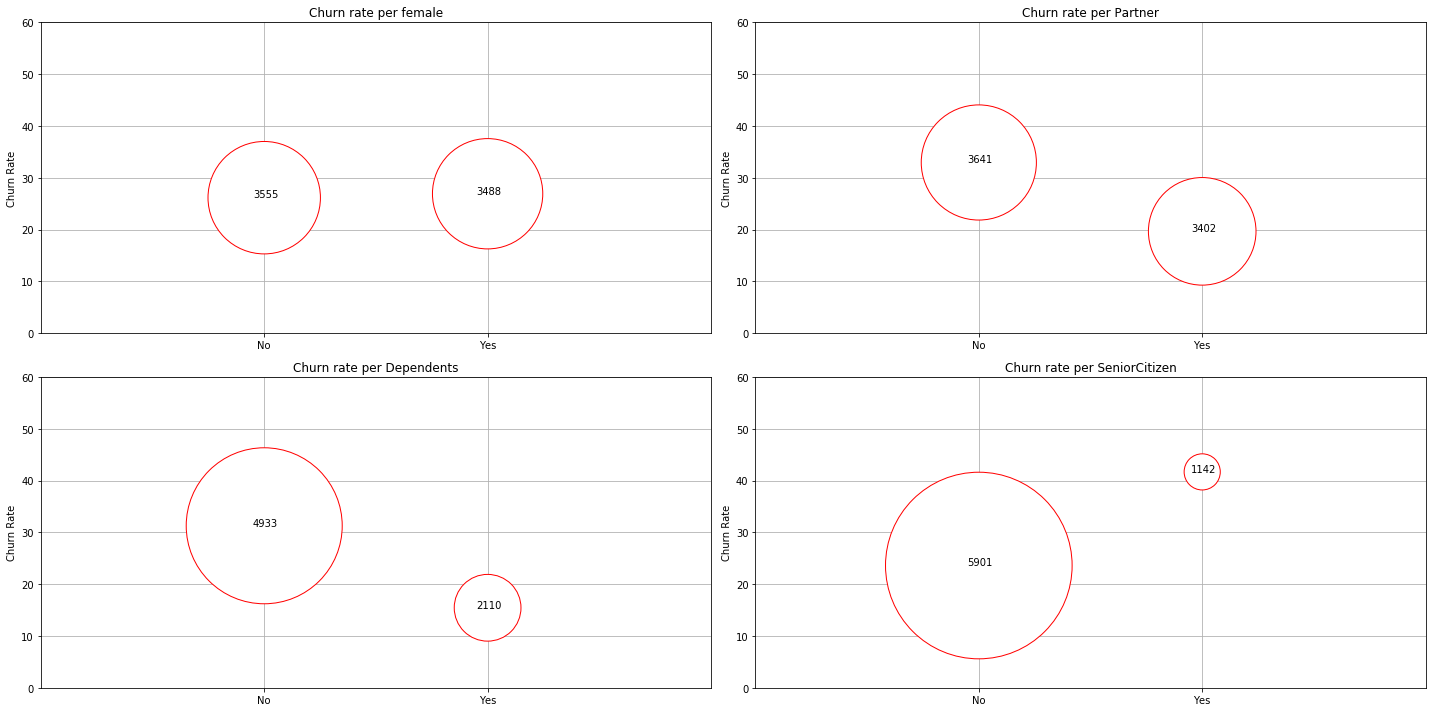

In [17]:
fig, axs = plt.subplots(2,2,figsize=(20,10))
plot_churn_per_attrib('female',0,0)
plot_churn_per_attrib('Partner',0,1)
plot_churn_per_attrib('Dependents',1,0)
plot_churn_per_attrib('SeniorCitizen',1,1)
fig.tight_layout()

## Analysis:
- senior citizens and single people are prone to churn
- no correlation between gender and churn rate

## 3.5 Billing-related Features

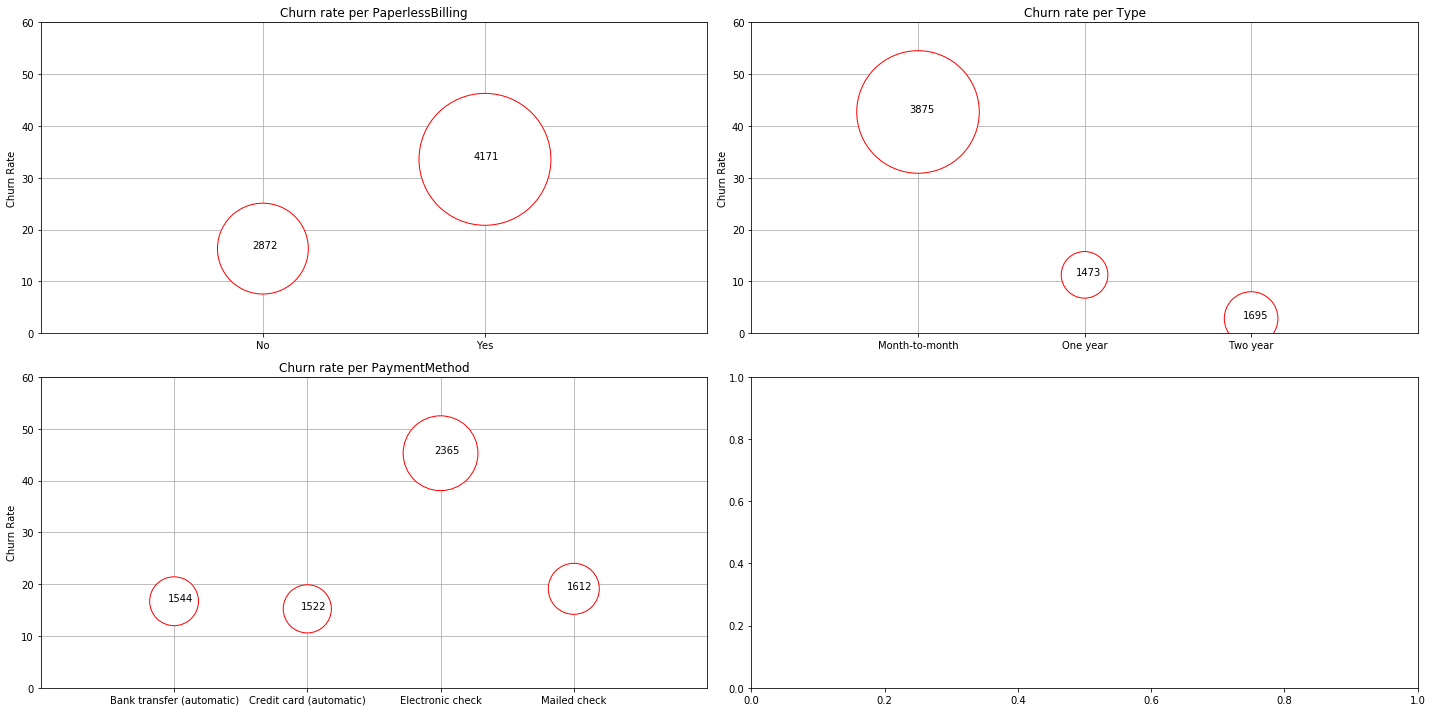

In [18]:
fig, axs = plt.subplots(2,2,figsize=(20,10))
plot_churn_per_attrib('PaperlessBilling',0,0)
plot_churn_per_attrib('Type', 0,1)
plot_churn_per_attrib('PaymentMethod',1, 0)
fig.tight_layout()

Charging per month:

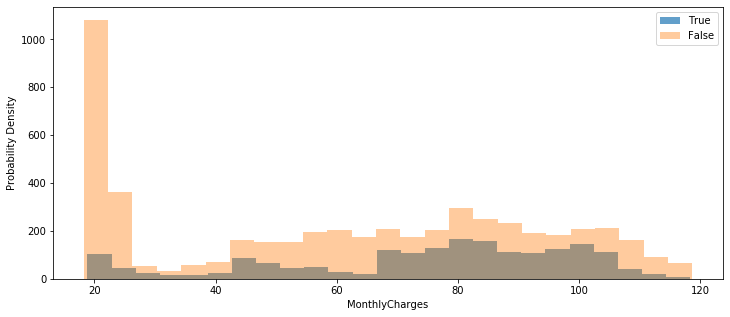

In [19]:
nbins = 25
plt.figure(figsize=(12, 5))
sns.distplot(df_customer[df_customer['churn']==True]['MonthlyCharges'], label='True', hist = True, kde=False, bins=nbins,hist_kws={'alpha':0.7})
sns.distplot(df_customer[df_customer['churn']==False]['MonthlyCharges'], label='False', hist = True, kde=False, bins=nbins,hist_kws={'alpha':0.4})
plt.legend()
plt.xlabel('MonthlyCharges')
plt.ylabel('Probability Density');

## Analysis
- Paperless may imply churning.
- Month-to-month payment mean higher churn - no wonder, as there is less bonding
- Electronic check result in higher churn - when compared to automatic.
- No significant correlation between monthly charging and churn.

## 3.6 Service related Features

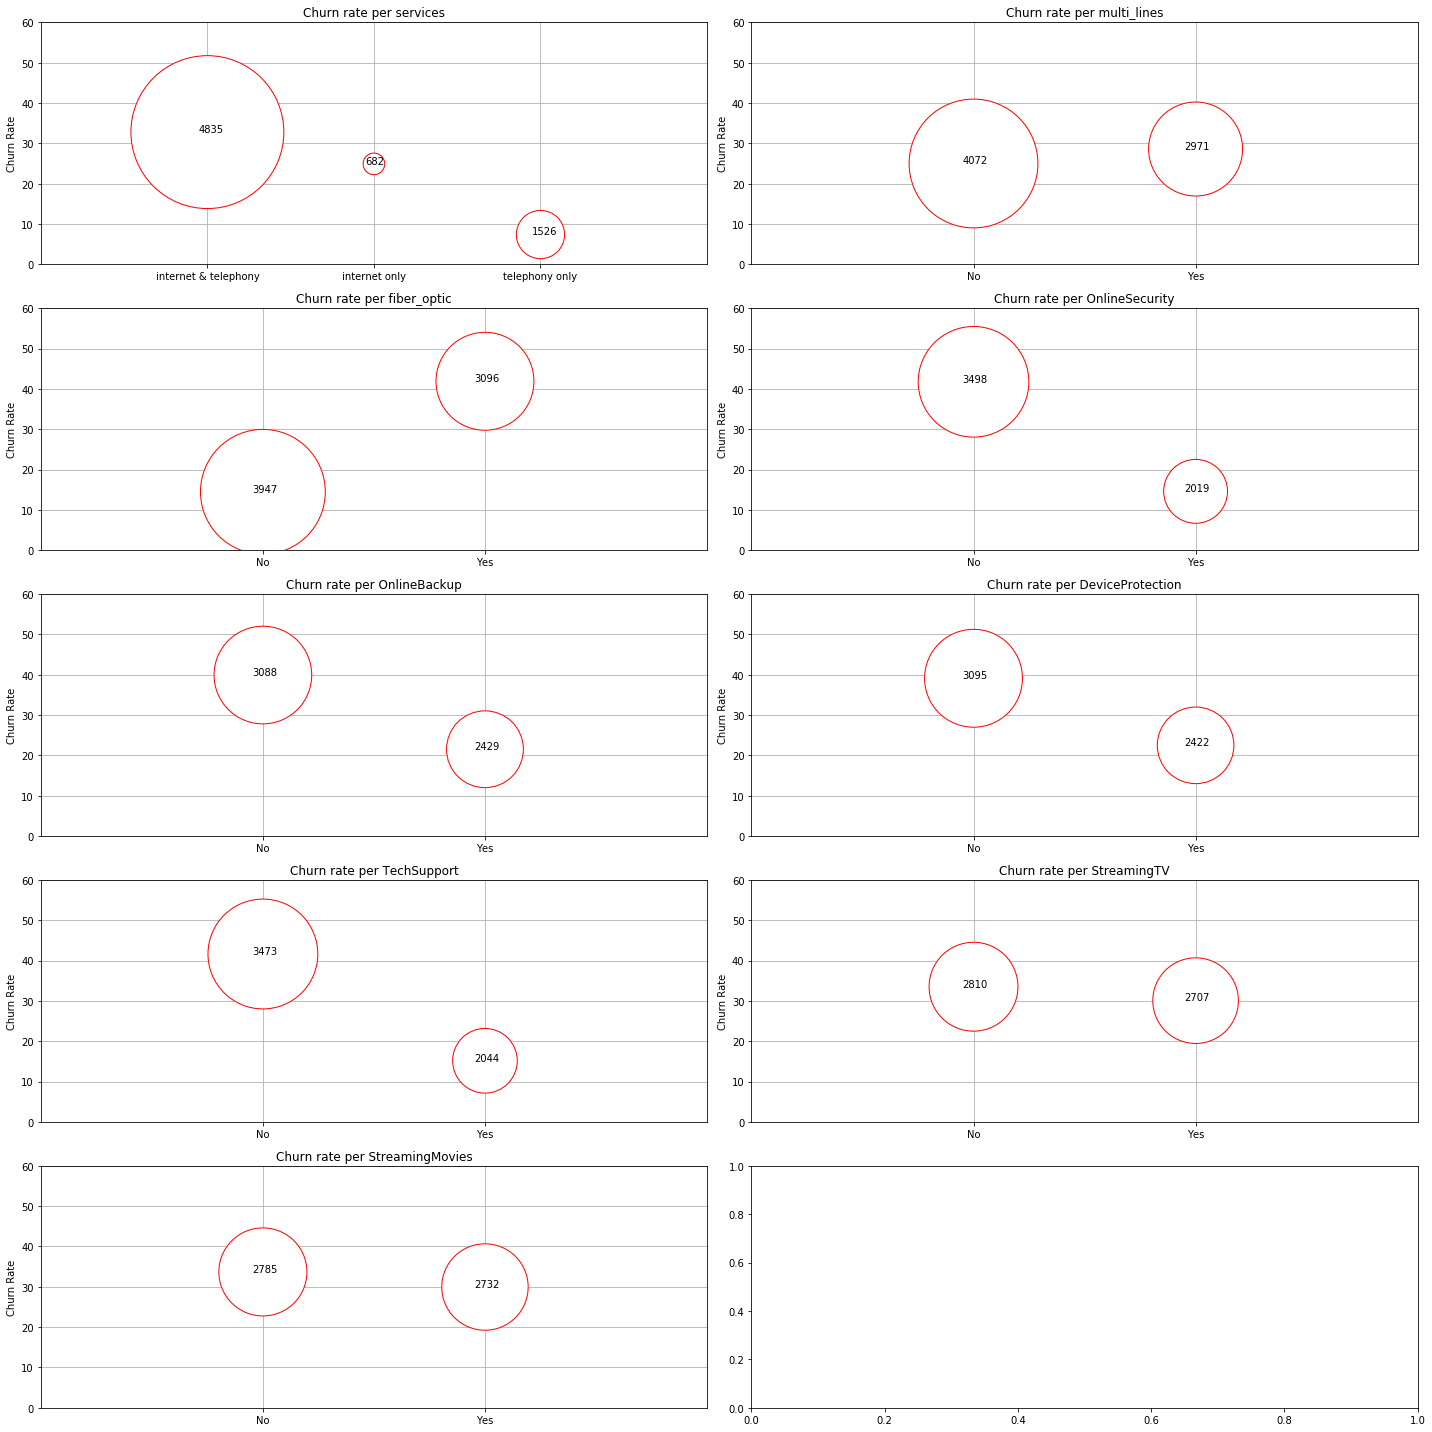

In [20]:
fig, axs = plt.subplots(5,2,figsize=(20,20))
plot_churn_per_attrib('services', 0, 0)
plot_churn_per_attrib('multi_lines', 0, 1)
plot_churn_per_attrib('fiber_optic', 1, 0)
plot_churn_per_attrib('OnlineSecurity', 1, 1)
plot_churn_per_attrib('OnlineBackup', 2, 0)
plot_churn_per_attrib('DeviceProtection', 2, 1)
plot_churn_per_attrib('TechSupport', 3, 0)
plot_churn_per_attrib('StreamingTV', 3, 1)
plot_churn_per_attrib('StreamingMovies', 4, 0)
fig.tight_layout()

## Analysis
- customer having both internet and telephony services have higher churn
- Multi-line does not correlate with churn
- Fiber-optic have higher churn compared to DSL - this is something requiring attention - maybe there is a service quality issue.
- Customers who have the Online security, online backup and Tech support tend less to churn - it may show the benefit of these services.
- No correlation between streaming services and churning - seems customers do not appreciate these services.

## 3.7 Churn rate per retention period

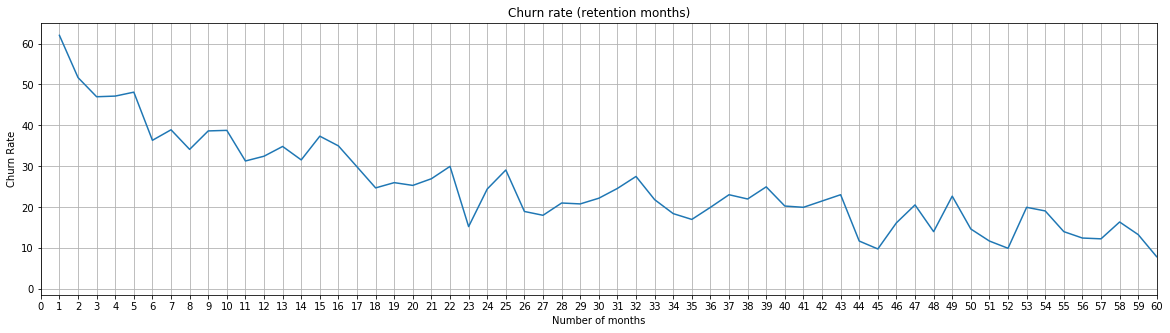

In [21]:
data_pivot = df_customer.pivot_table(index=['retention_months'], columns='churn', values='customerID', aggfunc='count')
data_pivot['churn_rate'] = 100*data_pivot[1] / (data_pivot[0] + data_pivot[1])

ax = data_pivot['churn_rate'][1:].plot(figsize=(20, 5), grid=True, title = 'Churn rate (retention months)')
ax.xaxis.set_major_locator(MultipleLocator(1))
ax.set_ylabel('Churn Rate')
ax.set_xlabel('Number of months')
ax.set_xlim(left=0, right= 60);

## Analysis
As we can see above, churn rate decreases over the time. The first few months have high risk of churn - 60% in the first month!

## 3.8 Churn rate per time passed since begin of service

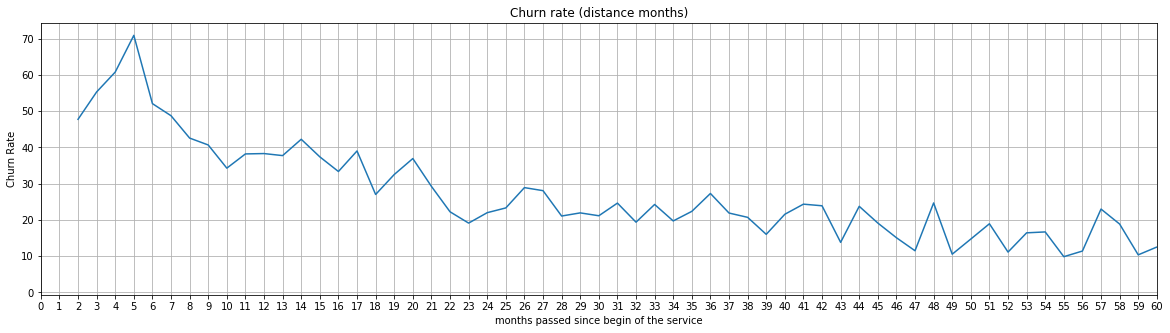

In [22]:
data_pivot = df_customer.pivot_table(index=['begin_distance_months'], columns='churn', values='retention_months', aggfunc='count')
data_pivot['churn_rate'] = 100*data_pivot[1] / (data_pivot[0] + data_pivot[1])
ax = data_pivot['churn_rate'][1:].plot(figsize=(20, 5), grid=True, title = 'Churn rate (distance months)')
ax.xaxis.set_major_locator(MultipleLocator(1))
ax.set_ylabel('Churn Rate')
ax.set_xlabel('months passed since begin of the service')
ax.set_xlim(left=0, right= 60);

## Analysis
As can be clearly noted, there is a BIG churn problem in the last 6 months..

## 3.9 Correlation between Categorical features

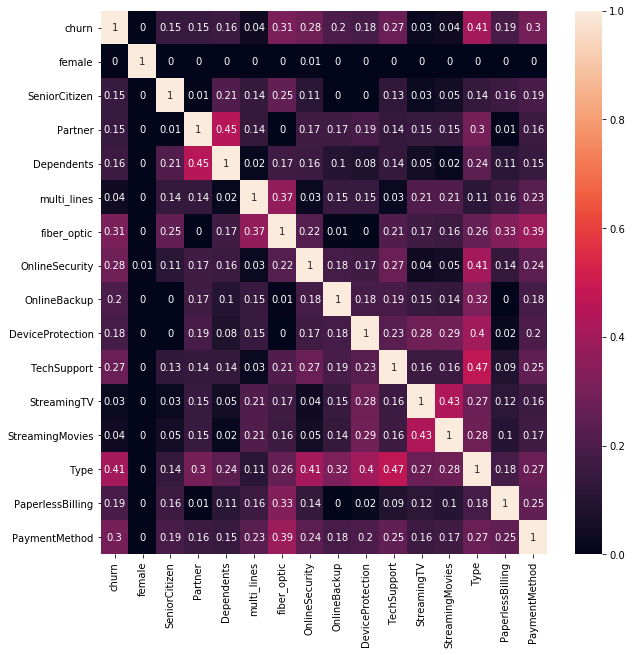

In [23]:
def cramers_v(confusion_matrix):
    """ calculate Cramers V statistic for categorial-categorial association.
        uses correction from Bergsma and Wicher,
        Journal of the Korean Statistical Society 42 (2013): 323-328
    """
    chi2 = ss.chi2_contingency(confusion_matrix)[0]
    n = confusion_matrix.sum()
    phi2 = chi2 / n
    r, k = confusion_matrix.shape
    phi2corr = max(0, phi2 - ((k-1)*(r-1))/(n-1))
    rcorr = r - ((r-1)**2)/(n-1)
    kcorr = k - ((k-1)**2)/(n-1)
    return round(np.sqrt(phi2corr / min((kcorr-1), (rcorr-1))),2)
df_categoricals = df_customer[['churn','female', 'SeniorCitizen', 'Partner', 'Dependents', 'multi_lines', 'fiber_optic', 'OnlineSecurity', 'OnlineBackup', 
            'DeviceProtection', 'TechSupport', 'StreamingTV', 'StreamingMovies', 'Type', 'PaperlessBilling', 'PaymentMethod']]
df = pd.DataFrame(columns=df_categoricals.columns)
for ir in df_categoricals.columns:
    for ic in df_categoricals.columns:
        df.loc[ir,ic] = cramers_v(pd.crosstab(df_categoricals[ir], df_categoricals[ic]).to_numpy())
plt.figure(figsize=(10,10))
sns.heatmap(df.astype(np.float64), annot=True);

## Analysis
- Strongest correlation for `churn`: `Type` (type of billing), `PaymentMethod` and `fiber_optics`
- `StreamingMovies' and `StreamingMovies'

# 4. Model

## 4.1 Preparations for modelling

### Filling missing values

In [24]:
df_customer.fillna('No', inplace=True)

### Drop columns not required for model

In [25]:
df_customer.drop(columns=['customerID', 'BeginDate', 'EndDate', 'TotalCharges', 'services'], inplace=True)

### One Hot Encoding

In [26]:
data_ohe = pd.get_dummies(df_customer, drop_first=True)
data_ohe['has_telephony'] = data_ohe['has_telephony'].astype(int)
data_ohe['has_internet'] = data_ohe['has_internet'].astype(int)
data_ohe['churn'] = data_ohe['churn'].astype(int)

### Data Split
- Train: 60%
- Validation: 20%
- Test: 20%

In [27]:
def split_groups (df, target_col):
    df_train, df_temp = train_test_split(df, test_size=0.4, random_state=12345)
    df_valid, df_test = train_test_split(df_temp, test_size=0.5, random_state=12345)

    features_train = df_train.drop([target_col], axis=1)
    target_train = df_train[target_col]
    features_valid = df_valid.drop([target_col], axis=1)
    target_valid = df_valid[target_col]
    features_test = df_test.drop([target_col], axis=1)
    target_test = df_test[target_col]
    return features_train, target_train, features_valid, target_valid, features_test, target_test

features_train, target_train, features_valid, target_valid, features_test, target_test = split_groups (data_ohe, 'churn')

### Helper functions

In [28]:
def learning_curve(train_scores, valid_scores, param_range, target):
    plt.figure(figsize=(9, 9))
    targets = [target]* len(train_scores)
    plt.plot(param_range, train_scores, 'o-', color="r", label="Training")
    plt.plot(param_range, valid_scores, 'o-', color="b", label="Validation")
    plt.plot(param_range, targets,'-', color="g", label="Target")
    plt.ylabel('Score') 
    plt.title('Learning Curve')
    plt.legend()
    plt.grid()
    plt.show()

In [29]:
def evaluate_model(model, train_features, train_target, test_features, test_target):
    eval_stats = {}
    fig, axs = plt.subplots(1, 3, figsize=(20, 6)) 
    for type, features, target in (('train', train_features, train_target), ('test', test_features, test_target)):
        eval_stats[type] = {}
        pred_target = model.predict(features)
        pred_proba = model.predict_proba(features)[:, 1]
        
        f1_thresholds = np.arange(0, 1.01, 0.05)
        f1_scores = [metrics.f1_score(target, pred_proba>=threshold) for threshold in f1_thresholds]
        
        fpr, tpr, roc_thresholds = metrics.roc_curve(target, pred_proba)
        roc_auc = metrics.roc_auc_score(target, pred_proba)    
        eval_stats[type]['ROC AUC'] = roc_auc

        precision, recall, pr_thresholds = metrics.precision_recall_curve(target, pred_proba)
        aps = metrics.average_precision_score(target, pred_proba)   # PRC
        eval_stats[type]['APS'] = aps
        
        if type == 'train':
            color = 'blue'
        else:
            color = 'green'

        # F1 Score
        ax = axs[0]
        max_f1_score_idx = np.argmax(f1_scores)
        ax.plot(f1_thresholds, f1_scores, color=color, label=f'{type}, max={f1_scores[max_f1_score_idx]:.2f} @ {f1_thresholds[max_f1_score_idx]:.2f}')
        # setting crosses for some thresholds
        for threshold in (0.2, 0.4, 0.5, 0.6, 0.8):
            closest_value_idx = np.argmin(np.abs(f1_thresholds-threshold))
            marker_color = 'orange' if threshold != 0.5 else 'red'
            ax.plot(f1_thresholds[closest_value_idx], f1_scores[closest_value_idx], color=marker_color, marker='X', markersize=7)
        ax.set_xlim([-0.02, 1.02])    
        ax.set_ylim([-0.02, 1.02])
        ax.set_xlabel('threshold')
        ax.set_ylabel('F1')
        ax.legend(loc='lower center')
        ax.set_title(f'F1 Score') 

        # ROC
        ax = axs[1]    
        ax.plot(fpr, tpr, color=color, label=f'{type}, ROC AUC={roc_auc:.2f}')
        # setting crosses for some thresholds
        for threshold in (0.2, 0.4, 0.5, 0.6, 0.8):
            closest_value_idx = np.argmin(np.abs(roc_thresholds-threshold))
            marker_color = 'orange' if threshold != 0.5 else 'red'            
            ax.plot(fpr[closest_value_idx], tpr[closest_value_idx], color=marker_color, marker='X', markersize=7)
        ax.plot([0, 1], [0, 1], color='grey', linestyle='--')
        ax.set_xlim([-0.02, 1.02])    
        ax.set_ylim([-0.02, 1.02])
        ax.set_xlabel('FPR')
        ax.set_ylabel('TPR')
        ax.legend(loc='lower center')        
        ax.set_title(f'ROC Curve')
        
        # PRC
        ax = axs[2]
        ax.plot(recall, precision, color=color, label=f'{type}, AP={aps:.2f}')
        # setting crosses for some thresholds
        for threshold in (0.2, 0.4, 0.5, 0.6, 0.8):
            closest_value_idx = np.argmin(np.abs(pr_thresholds-threshold))
            marker_color = 'orange' if threshold != 0.5 else 'red'
            ax.plot(recall[closest_value_idx], precision[closest_value_idx], color=marker_color, marker='X', markersize=7)
        ax.set_xlim([-0.02, 1.02])    
        ax.set_ylim([-0.02, 1.02])
        ax.set_xlabel('recall')
        ax.set_ylabel('precision')
        ax.legend(loc='lower center')
        ax.set_title(f'PRC')        

        eval_stats[type]['Accuracy'] = metrics.accuracy_score(target, pred_target)
        eval_stats[type]['F1'] = metrics.f1_score(target, pred_target)
    
    df_eval_stats = pd.DataFrame(eval_stats)
    df_eval_stats = df_eval_stats.round(2)
    df_eval_stats = df_eval_stats.reindex(index=('Accuracy', 'F1', 'APS', 'ROC AUC'))
    print(df_eval_stats)

## 4.2 Random Forest Model

/opt/conda/lib/python3.7/site-packages/sklearn/ensemble/forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
/opt/conda/lib/python3.7/site-packages/sklearn/ensemble/forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
/opt/conda/lib/python3.7/site-packages/sklearn/ensemble/forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
/opt/conda/lib/python3.7/site-packages/sklearn/ensemble/forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
/opt/conda/lib/python3.7/site-packages/sklearn/ensemble/forest.py:245: FutureWarning: The de

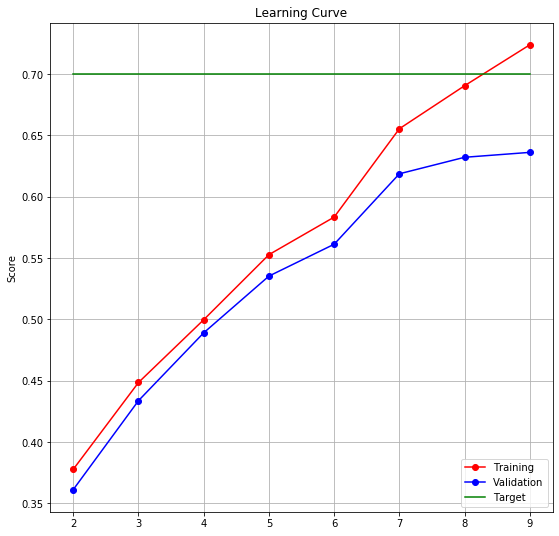

In [30]:
train_f1_scores = []
valid_f1_scores = []
param_range = []
for depth in range(2,10):
    model = RandomForestClassifier(random_state=12345, max_depth=depth, class_weight=None)
    model.fit(features_train, target_train)
    param_range.append(depth)
    train_f1_scores.append(f1_score(target_train, model.predict(features_train)))
    valid_f1_scores.append(f1_score(target_valid, model.predict(features_valid)))
learning_curve(train_f1_scores, valid_f1_scores, param_range, 0.7)

As displayed in above learning curve, value of `max_depth`=7' might be optimal, since overfit can be noticed at higher values.

/opt/conda/lib/python3.7/site-packages/sklearn/ensemble/forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
/opt/conda/lib/python3.7/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/opt/conda/lib/python3.7/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


               train        test
Accuracy        0.85        0.81
F1              0.66        0.58
APS             0.80        0.73
ROC AUC         0.91        0.86


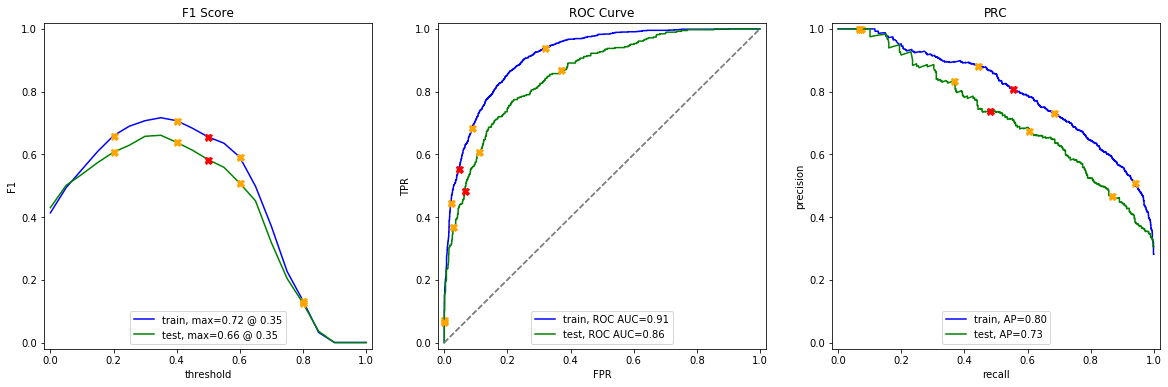

In [31]:
model = RandomForestClassifier(random_state=12345, max_depth=7, class_weight=None)
model.fit(features_train, target_train)
evaluate_model(model, features_train, target_train, features_test, target_test)

## 4.3 CatBoost Model

Learning rate set to 0.5
0:	learn: 0.4741311	total: 53ms	remaining: 371ms
3:	learn: 0.3321846	total: 63ms	remaining: 63ms
6:	learn: 0.2831968	total: 77.6ms	remaining: 11.1ms
7:	learn: 0.2700278	total: 81.1ms	remaining: 0us


/opt/conda/lib/python3.7/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/opt/conda/lib/python3.7/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


               train        test
Accuracy        0.89        0.88
F1              0.76        0.74
APS             0.88        0.87
ROC AUC         0.94        0.91


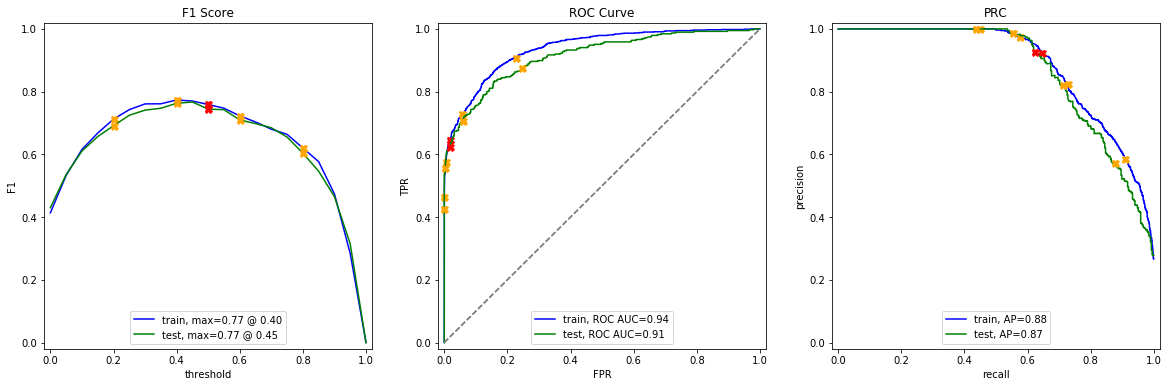

In [32]:
model = CatBoostClassifier(loss_function="Logloss", iterations=8)
model.fit(features_train, target_train, verbose=3)
#pred_valid = model.predict(features_valid)

evaluate_model(model, features_train, target_train, features_test, target_test)

## 4.4 XGBoost Model

/opt/conda/lib/python3.7/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/opt/conda/lib/python3.7/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


               train        test
Accuracy        0.91        0.85
F1              0.79        0.66
APS             0.93        0.82
ROC AUC         0.96        0.90


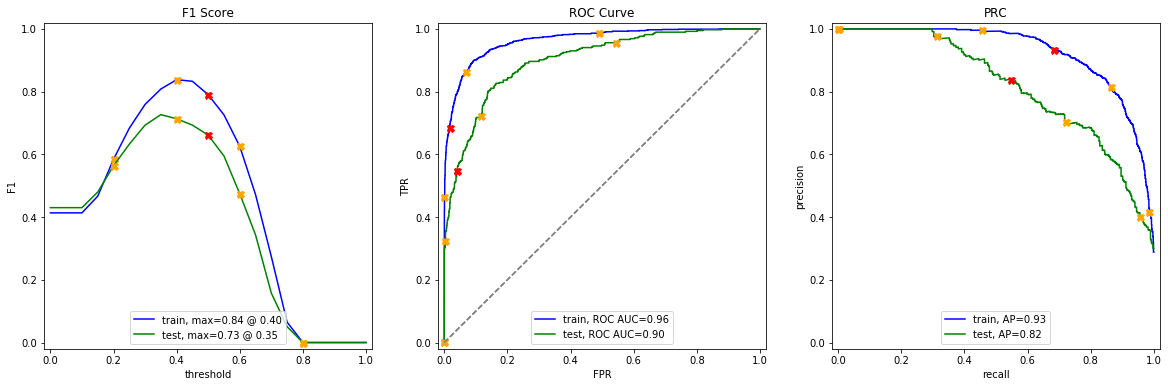

In [33]:
import xgboost as xgb
model = xgb.XGBClassifier(objective ='reg:logistic', colsample_bytree = 0.3, learning_rate = 0.1,
                max_depth = 12, alpha = 10, n_estimators = 15)
model.fit(features_train, target_train, verbose=3)
evaluate_model(model, features_train, target_train, features_test, target_test)

<div class="alert alert-block alert-info">
BTW, that is an interesting F1 curve. What is so special about XGBoost that F1 goes to 0 after certain threshold? Is it a bad sign or a good one? Can it be fixed (if required) wuth hyperparameter tuning?
</div>

## 4.5 Modeling results analysis:


| Model         | ROC-AUC |Accuracy |
| :------------ | ---- |---- |
| Random Forest |0.86  |0.81  |
| CatBoost      |0.89  |0.85  
| XGBoost       |0.90  |0.85  |

As can be clearly seen - XGBoost, provides the best results.

# 5. Conclusions and next steps

**High churn rate, especially in the last 6 months.**

High churn rate on:

- Singles with no dependents
- Senior citizens
- Paperless billing reports
- Payment plan: month-by-month
- Payment method: electronic check
- Internet infrastructure: fiber-optics (may point quality of service issues)
- Customer with no value added Internet features (except streaming).
- New customers in the first 36 months
- Customers who joined in the last 6 months.

## Project Plan:

1. 16/09       Code submission
2. 17-18/09    Report preparation
3. 18/09       Report submission
4. 18-19/09    Peer-to-peer review
5. 20-21/09    Preparation of final project
6. 22/09       Final project submission

# 6. Report

## 6.1 Mission statement
The telecom operator Interconnect would like to be able to forecast their churn of clients. If it's discovered that a user is planning to leave, they will be offered promotional codes and special plan options. Interconnect's marketing team has collected some of their clientele's personal data, including information about their plans and contracts. 

## 6.2 Metrics
- We are using the following notations:
  - FP (False Positive) - a client was offered promotional codes, but wasn't actually going to leave – i.e, we may spend on promotional codes, without profiting from it.
  - FN (False Negative) - a client wasn't offered anything and left – i.e., money lost
  - TP – a customer left as predicted.
  - TN – a customer stayed as predicted.
- We have income data, but no cost information (cost of keeping and cost of losing a customer). Therefore, we cannot use a business metric based on profit (= income – cost).
- Therefore, we will use technical metrics in order to select best model:
  - Primary metric: AUC-ROC – it calculates how TP rate and FP rate trade off.
  - Secondary metric: accuracy – the difference between model prediction (TP + TN) to the actual result.

<div class="alert alert-block alert-success">
I like you've grabbed the idea how FN/FP are connected to the business case. That's when ML starts to be seen as probably practically useful thing. )) You are right about the consequences of the cost being unknown so the best we can do is to show how we can balance between four possible prediction outcomes.
</div>

## 6.3 Overview of the work been done
1. Data Exploration and Analysis – Completed
2. Clarification of open questions (meaning of null data, and churn indication) – Completed
3. Initial modeling - The initial models provided poor results (ROC-AUC below 8.0 and low accuracy on training set). The low accuracy on the training set can indicate high bias (underfitting) which can be attributed to not enough features – this led us back to Data Analysis - Completed
4. Additional  Data Exploration and Analysis - Completed
  - we made a better look on date columns (BeginDate and EndDate) and produced 2 new features:
    - The lifecycle of a customer in months (End – Begin)
    - The month index a customer joined the service
  - Indeed, we found correlation between these features and churn.
  - Therefore, we replaced the current dates features by these new ones.
5. 2nd cycle of modeling - Completed
  - We decided on the following 3 models: Random Forest, CatBoost and XGBoost
  - All 3 models provided good results, with XGBoost outshining.
6. Reporting (this section) - Completed

<div class="alert alert-block alert-info">
<p>Thank you for going through the plan and describing results per each item. Just a word of precaution. The couple of new features (End-Begin, Month Index) may lead to so called feature leakage when there appears a feature which is strongly associated with a target. In our case, all customers joined in January 2020 are strongly associated with the 'no churn' tagret value.</p>
    
I do not know the percentage of these customers, if is low, the leakage is not so important and we can live with it. If the percentage is high, the model can be too straightforward and provide good results for both the train/test parts but suboptimal results when being put to the practice.
</div>

## 6.4 Modeling result
Out of the 3 tested models, XGBoost provide superior results (on test set):
- ROC-AUC: 0.90
- Accuracy: 0.85

<div class="alert alert-block alert-success">
Good results! That's worth 6 SP!
</div>

## 6.5 Main Finding
1. Profile of customers with high risk to churn
   - Status single:  30% vs. 20%
   - No dependents: 30% vs. 15%
   - Senior citizen: 40% vs. 20%
2. When do customers churn? In the first 3 months (50% vs. 20%)
3. Billing parameters affecting churn
   - Monthly payment: 45% vs 10%
   - Manual payment: 45% vs. 15%
   - Paperless: 35% vs. 15%
4. Service parameter affecting churn
   - Fiber-optics: 40% vs. 15%
   - No online services (tech support, device protection, security, backup) : 40% vs. 15%
5. Churn prediction – we have a good model that will enable prediction of customers about to leave.
6. Fiber-optics : surprisingly higher churn rate – may indicate service quality issues.
7. Additional point – high churn rate in the last 6 months. During this period a massive number of subscribers joined the service - we suspect that churn might be related to service quality (capacity overflow of the customer service personnel).

<div class="alert alert-block alert-success">
You have provided objective findings on the churn, which is great. There are some handy numbers to discuss with our customer, let's see at the meeting with them if they can put somethin based on them into action e.g. they can offer special plans to senior citizen to minimize the churn. BTW, that's suprising serior citizen are more likely to churn than all the others. It is usually otherwise... Worth additional investigation? Let's raise that point at the meeting.
</div>

# 6.6 Recommendations
1. Recommendation regarding customers identified as in risk:
   - Customers using monthly payment – promote yearly plan
   - Customers paying manually – promote automatic payment
   - Send paper billing
   - Customer having both Telephony and Internet – promote online services.
2. Priority should be given to customers who joined the service in the last 3 months.

<div class="alert alert-block alert-success">
Those are handy ideas! That'd be interesting to model what ratio of customers we are likely to lose in the next month if e.g. no priority is given to customers using monthly payment and so on per each item above. Let that be our next steps if we agee on the project budget with the customer.
</div>

<div class="alert alert-block alert-success">
1. That's true. 'No' for EndDate means a client is still with us.
    
2, 3. Yes, I believe so. I can see you have merged all data into one dataframe in the beginning so Null for either MultipleLine or InternetService means there were no records in the relevant data files.
    
BTW, I can see you have tried to understand association between features with the scatterplots. You may want to calculate correlation coefficients as well and put it in the form of a table, might be easier.
</div>

<div class="alert alert-block alert-success">
<p>What I am really missing is an action plan. Can you please outline, 3-5 points, what are going to do? Our business deparment expects we check whether the data as such can be used for building a model with a good decision 'power' on whether a customer will churn.</p>

I suggest using the ROC AUC metric so to understand whether it is possible to find a good balance between TPR (we correctly recognize a customer who is going to churn and spend our marketting budget on them correctly) and FPR (we do a mistake and spend our marketting budget on them incorrectly). Let's build 3-4 models to compare them.
</div>